This code is the dummy code that:

Input: 
- random "fidelity" F from 0 to 1
- property P that was calculated from F

Output:
- Macchine learned `model` that given P output a predicted F

In [11]:
import numpy as np
from qutip import *

# --- Define the ideal case ---

# Ideal state |+><+|
plus_state = (basis(2,0) + basis(2,1)).unit()
rho_ideal = plus_state * plus_state.dag()

# Ideal channel: S gate
S_gate = Qobj([[1,0],[0,1j]])

# Ideal measurement: X basis
plus = (basis(2,0) + basis(2,1)).unit()
minus = (basis(2,0) - basis(2,1)).unit()
M_ideal = plus * plus.dag()

In [12]:
def apply_measurement(rho,M):
    prob = (M * rho * M.dag()).tr()
    return 1 if prob > 0.5 else -1

def apply_measurement_raw_prob(rho,M):
    prob = (M * rho * M.dag()).tr()
    return prob

def apply_sequence(rho, sequence):
    """Apply a sequence of unitary gates to rho."""
    rho_out = rho
    for g in sequence:
        rho_out = g * rho_out * g.dag()
    return rho_out

def experiment_raw_prob(rho,gate,M):
    sequences = [
        [],                        # ε
        [gate, gate],              # SS
        [gate, gate, gate, gate]   # SSSS
    ]

    results = []
    for sequence in sequences:
        rho_out = apply_sequence(rho,sequence)
        result = apply_measurement_raw_prob(rho_out, M)
        results.append(result)

    return results

def experiment_prob_failing(rho,gate,M):
    results = experiment_raw_prob(rho,gate,M) #will be sth like [a,b,c]
    ideal_results = [1,0,1]
    prob_failing = [round(abs(ideal_results[i] - results[i]),6) for i in range(len(results))] #[1-a, b-0, 1-c]
    return prob_failing

In [13]:
def average_fidelity(rho, gate, M):
    avg_fid = (fidelity(rho, rho_ideal) + average_gate_fidelity(gate, S_gate) + fidelity(M, M_ideal)) / 3
    return round(avg_fid, 6)


In [14]:
experiment_prob_failing(rho_ideal,S_gate,M_ideal)
average_fidelity(rho_ideal,S_gate,M_ideal)

np.float64(1.0)

In [15]:
rho_exp = qutip.rand_dm(2)
M_exp = ket2dm(qutip.rand_ket(2))
gate_exp = qutip.rand_unitary(2)
experiment_prob_failing(rho_exp,gate_exp,M_exp)
average_fidelity(rho_exp,gate_exp,M_exp)

np.float64(0.505634)

In [16]:
def depolarize(rho, p):
    """Apply depolarizing noise with probability p to state rho."""
    dim = rho.shape[0]
    return (1 - p) * rho + p * qeye(dim) / dim

In [21]:
N = 10000
F = []
P = []
for i in range(N):
    rho_exp = qutip.rand_dm(2)
    M_exp = ket2dm(qutip.rand_ket(2))
    gate_exp = qutip.rand_unitary(2)
    F.append(average_fidelity(rho_exp,gate_exp,M_exp))
    P.append(experiment_prob_failing(rho_exp,gate_exp,M_exp))

d:\Program Files\python\Lib\site-packages\qutip\core\data\expm.py:136: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


In [22]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


In [25]:
# Convert to PyTorch tensors
X = torch.tensor(P, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F, dtype=torch.float32).unsqueeze(1)  # output: fidelity

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# Simple MLP model
# -----------------------------
# model = nn.Sequential(
#     nn.Linear(3, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
# -----------------------------
epochs = 50
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.014548
Epoch 20, Loss: 0.007086
Epoch 30, Loss: 0.025078
Epoch 40, Loss: 0.014042
Epoch 50, Loss: 0.009959


In [40]:
# -----------------------------
# Test prediction
# -----------------------------
rho_exp = qutip.rand_dm(2)
M_exp = ket2dm(qutip.rand_ket(2))
gate_exp = qutip.rand_unitary(2)
test_P = torch.tensor(experiment_prob_failing(rho_exp,gate_exp,M_exp))
test_F = average_fidelity(rho_exp,gate_exp,M_exp)
pred_F = model(test_P).detach().numpy()
print("True F:", test_F)
print("Predicted F:", pred_F.flatten())


True F: 0.628727
Predicted F: [0.61524814]


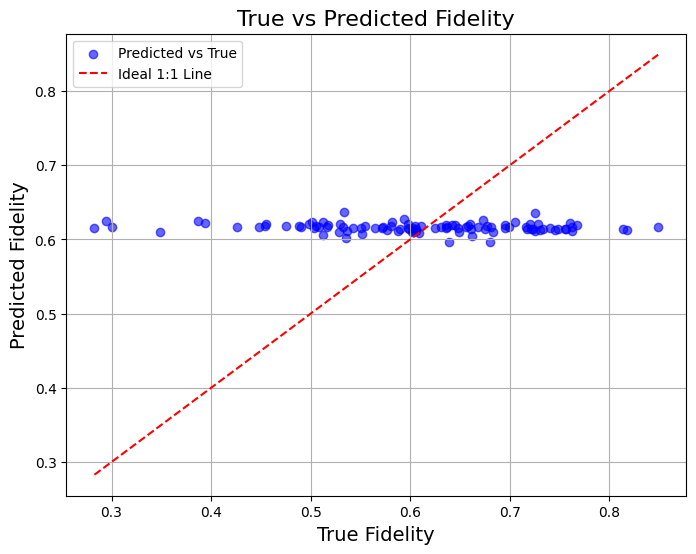

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import qutip

# -----------------------------
# Test prediction
# -----------------------------
num_test_samples = 100  # Number of test cases
true_fidelities = []
pred_fidelities = []

# Loop over multiple test cases
for _ in range(num_test_samples):
    # Generate random test data (rho, M, and gate)
    rho_exp = qutip.rand_dm(2)
    M_exp = qutip.ket2dm(qutip.rand_ket(2))
    gate_exp = qutip.rand_unitary(2)

    # Get the test probability and fidelity
    test_P = torch.tensor(experiment_prob_failing(rho_exp, gate_exp, M_exp)).unsqueeze(0)  # Batch dimension (1 sample)
    test_F = average_fidelity(rho_exp, gate_exp, M_exp)

    # Get the model prediction
    pred_F = model(test_P).detach().numpy().flatten()

    # Store the results
    true_fidelities.append(test_F)
    pred_fidelities.append(pred_F)

# Convert lists to numpy arrays for plotting
true_fidelities = np.array(true_fidelities)
pred_fidelities = np.array(pred_fidelities)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(true_fidelities, pred_fidelities, color='blue', label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(true_fidelities), max(true_fidelities)], [min(true_fidelities), max(true_fidelities)], 'r--', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("True Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("True vs Predicted Fidelity", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
